In [1]:
expt_names = ["derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task"]

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.key_dataset import remove_overlaps, select_keys, create_windows, KeyDataset
from src.data.filter import Filter
from src.data.utils import bipolar_conversion, load_data, key_counts, load_data_deprecated
from src.visualization.visualize import layout
from src.utils import load_config
from src.models.keydecoder import KeyDecoder
from src.models.train import train
from src.models.utils import Experiment

import importlib
import operator
from functools import reduce

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
rhythm_layout = ['a', 's', 'd', 'f']
binary_layout = [0, 1]
right_layout = ['j', 'k', 'l', ';']
six_finger_layout = ['a', 's', 'd', 'f', 'g', 'h']
new_layout = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
two_fingers_layout = ['g', 'h']
four_finger_layout = ['a', 'c', 'd', 'e']

window_pre = 1000 #//2
window_post = 1000 #//2
subwindow_len = 480 #//2

In [4]:
data_dir = "/home/john/rumi/data/"

def get_data(expt_list, layout, filter_params=None):
    datasets = []

    for expt_name in expt_list:
        key_fname = data_dir + expt_name + "/data_streams/key_stream.bin"
        emg_fname = data_dir + expt_name + "/data_streams/emg_stream.bin"
        key_data = load_data(key_fname)
        emg_data = load_data(emg_fname)
        emg_names = ['emgbuffer'] + list(emg_data.dtype.names)[1:]
        key_names = ['keybuffer'] + list(key_data.dtype.names)[1:]
        emg_data.dtype.names = emg_names
        key_data.dtype.names = key_names
        print([chr(i) for i in key_data['keybuffer'][:80, 1]])
        
#         print(emg_data.shape)
#         for i in range(0, 100):
#            print(emg_data[i][-1])
        new_key_data = np.zeros(key_data.size, 
                                dtype=[('keybuffer', '<i8', (3,)), ('emg_stream_step', '<i8'), ('key_stream_step', '<i8'), ('time_ns', '<i8')])
        new_key_data['keybuffer'] = np.concatenate((np.zeros_like(key_data['keybuffer'][:, 1:2]), 
                                                key_data['keybuffer']), axis=1)
        new_key_data['emg_stream_step'] = key_data['emg_stream_step']
        new_key_data['key_stream_step'] = key_data['key_stream_step']
        new_key_data['time_ns'] = key_data['time_ns']

        emg_stream = emg_data['emgbuffer']
        
        print(key_data[:10])
        
        
        
#         for i in new_key_data:
#            if(i[0][1] != 0):
#                print(i)
        
        dataset = KeyDataset(emg_stream, new_key_data, layout, window_pre, window_post, subwindow_len,
                             start_channel=1, 
                             end_channel=65, bipolar=False, avg_ref=True, binary=False, 
                             include_blanks=False, 
                             limit_blanks=False,
                             filter_params=filter_params)

        datasets.append(dataset)
    full = reduce(operator.add, datasets)
    full.print_counts()
    data = full.to_numpy(include_full_windows=True)
    return data

In [5]:
#fs = 2000.0
#filter_params = {'fs': fs, 'fc': (10, min(1000.0, 0.5*fs - 1))}
fs = 4000.0
filter_params = None
print('filter_params: ',  filter_params)
data = get_data(expt_names, new_layout, filter_params=filter_params)
print(data.dtype)

filter_params:  None
['a', 'a', 'e', 'h', 'd', 'a', 'g', 'h', 'b', 'f', 'e', 'b', 'g', 'b', 'g', 'g', 'b', 'b', 'g', 'f', 'e', 'f', 'g', 'h', 'a', 'g', 'a', 'a', 'a', 'h', 'b', 'f', 'a', 'b', 'a', 'h', 'd', 'g', 'f', 'h', 'h', 'g', 'b', 'd', 'f', 'h', 'd', 'b', 'e', 'h', 'h', 'f', 'h', 'g', 'b', 'b', 'e', 'a', 'd', 'd', 'd', 'e', 'f', 'f', 'g', 'g', 'f', 'd', 'h', 'b', 'b', 'g', 'f', 'a', 'g', 'b', 'g', 'f', 'd', 'f']
[([1727385568420319942,                  97], 14683, 0, 1727385568423831865)
 ([1727385569217687101,                  97], 17882, 1, 1727385569218900553)
 ([1727385570015092953,                 101], 21082, 2, 1727385570019081272)
 ([1727385570812017017,                 104], 24281, 3, 1727385570814147296)
 ([1727385571620063351,                 100], 27481, 4, 1727385571623853093)
 ([1727385572428477191,                  97], 30748, 5, 1727385572428930503)
 ([1727385573240923328,                 103], 34015, 6, 1727385573244200126)
 ([1727385574055728232,                

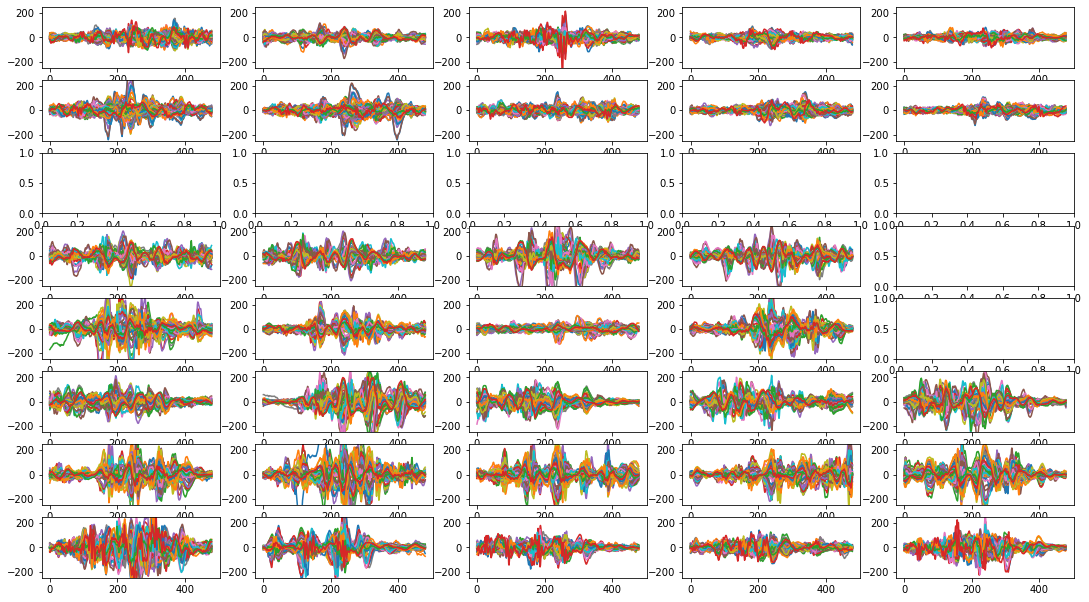

In [6]:
##VIS CODE
y = data['emg_windows']
x = np.arange(0, subwindow_len)

# plot early data: 
# grab dimensions from data object
fig, axes = plt.subplots(8,5)
fig.set_size_inches(18.5, 10.5, forward=True)
subplot_tracker = 8*[0]
for i in range(0, 50):
#     if(chr(int(data['key_label'][i])) not in ['h']):
#         continue

#     print(np.mean(np.abs((y[i, 240, :]))))
    row_plot = int(data['key_label'][i]) - ord("a")
    if subplot_tracker[row_plot] > 4: 
        continue
#     axes[row_plot][subplot_tracker[row_plot]].set_title(chr(int(data['key_label'][i])))
    for j in range(0, 64):
#         if(j == 31 or j == 30 or j == 32 or j == 29):
#             continue
        axes[row_plot][subplot_tracker[row_plot]].plot(x, y[i, :, j])
    
    axes[row_plot][subplot_tracker[row_plot]].set_ylim(-250,250)
    subplot_tracker[row_plot] = subplot_tracker[row_plot] + 1
    
plt.show()

In [7]:
config = load_config("/home/john/emg_decoder/configs/keydecoder.yaml")
#config['model']['data_scale'] = 1.0e6

In [8]:

train_data, val_test_data = train_test_split(data,
#                                             train_size=config['data']['train_proportion'],
                                             train_size=0.8,
                                            stratify=data['key_label'],
                                            random_state=config['random_seed'])

relative_val_proportion = config['data']['val_proportion'] / (1 - config['data']['train_proportion'])

# val_data = val_test_data
val_data, test_data = train_test_split(val_test_data,
                                      train_size=0.5,
                                       stratify=val_test_data['key_label'],
                                       random_state=config['random_seed'])


# test_data = data_test


train_dataset = KeyDataset(None, None, None, None, None, subwindow_len, init=False, binary=True)
train_dataset.full_windows = train_data['full_windows']
train_dataset.X = train_data['emg_windows']
train_dataset.start_idxs = train_data['start_idxs']
train_dataset.y = train_data['key_label']
train_dataset.num_chans = train_dataset.X.shape[-1]

train_dataset.print_counts()
for class_id in np.unique(train_dataset.y):
    train_dataset.augment_class(class_id, target_num_samples=target, num_views = 10, var_factor=4, time_shift=True, add_noise=False, in_place=True)
train_dataset.print_counts()
train_data = train_dataset.to_numpy(include_full_windows=False)

97, a: 79
98, b: 80
100, d: 80
101, e: 80
102, f: 80
103, g: 80
104, h: 80
97.0, a: 869
98.0, b: 880
100.0, d: 880
101.0, e: 880
102.0, f: 880
103.0, g: 880
104.0, h: 880


In [9]:
name = expt_names[0] + "_multiclass"
# name = 'shreyas_testing_combined_balanced_noblanks'

print(name)
print(train_dataset.to_numpy(include_full_windows=False).size, val_data.size, test_data.size)
processed_data_dir = "/home/john/emg_decoder/data/processed/"
train_path = processed_data_dir + name + "_train.npy"
val_path = processed_data_dir + name + "_val.npy"
test_path = processed_data_dir + name + "_test.npy"
path = processed_data_dir + name
np.save(train_path, train_dataset.to_numpy(include_full_windows=False))
np.save(val_path, val_data)
#
#
np.save(test_path, test_data)

config['data']['window_length'] = subwindow_len
config['model']['loss'] = 'CrossEntropyLoss'
config['data']['train_path'] = train_path
config['data']['val_path'] = val_path
config['data']['test_path'] = test_path
config['name'] = name
config['root_dir'] = "/home/john/emg_decoder"

derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass
6149 70 70


In [10]:
system_type = KeyDecoder
experiment_dir = f"/home/john/emg_decoder/models/{config['name']}"
accelerator = 'cuda'
devices = [0]

system, trainer = train(
        system_type,
        config,
        experiment_dir=experiment_dir,
        accelerator=accelerator,
        devices=devices,
#         devices=1,
    run=True
    )

Seed set to 4995


/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


data_scale tensor(1.)


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/john/emg_decoder/models/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass/lightning_logs


/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


2024-09-26 14:35:36.997612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 14:35:38.931702: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | loss  | CrossEntropyLoss   | 0     
1 | acc   | MulticlassAccuracy | 0     
2 | model | KeyClassifier      | 147 K 
---------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     T

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/john/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [11]:
expt = Experiment(system_type, experiment_dir, version=0)
LIST_of_checkpoints = expt.list_checkpoints()[1:]
print(LIST_of_checkpoints)

Versions: ['0'] available, loading version 0...
['bell-epoch=32-val_loss=0.00.ckpt', 'last.ckpt', 'bell-epoch=46-val_loss=0.00.ckpt', 'bell-epoch=50-val_loss=0.00.ckpt', 'bell-epoch=40-val_loss=0.00.ckpt']


In [12]:
experiment_dir

'/home/john/emg_decoder/models/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass'

bell-epoch=32-val_loss=0.00.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9285714030265808
        test_loss           0.4934372007846832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

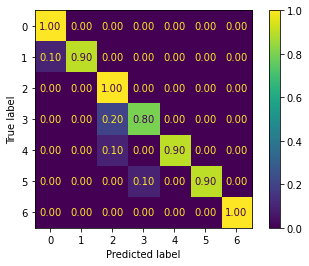

last.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9428571462631226
        test_loss           0.44889914989471436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

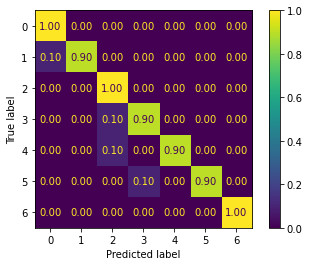

bell-epoch=46-val_loss=0.00.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9142857193946838
        test_loss           0.6770932078361511
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

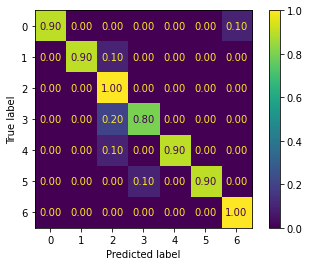

bell-epoch=50-val_loss=0.00.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9428571462631226
        test_loss           0.44889914989471436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

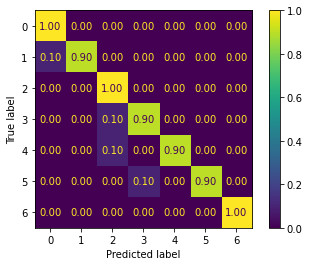

bell-epoch=40-val_loss=0.00.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9285714626312256
        test_loss            0.424344539642334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

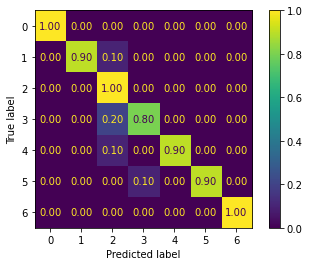

/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9428571462631226
        test_loss           0.44889914989471436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

best ckpt:  [{'test_loss': 0.44889914989471436, 'test_acc': 0.9428571462631226}]


In [13]:
# system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + "last.ckpt")
# trainer.test(system)
# out = trainer.predict(system)

best_ckpt = ''
best_acc = 0
for ckpt in LIST_of_checkpoints: 
    print(ckpt)
    system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + ckpt, strict=False)
    ret = trainer.test(system)
    if ret[0]['test_acc'] > best_acc:
        best_ckpt = ckpt
        best_acc = ret[0]['test_acc']
    out = trainer.predict(system)
    ys = np.concatenate([a[1] for a in out])
    preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])
    disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')
    plt.show()
system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + best_ckpt, strict=False)
test_perf = trainer.test(system)
out = trainer.predict(system)
print('best ckpt: ', test_perf)

In [14]:
# # if i want to override the choice
# best_ckpt = "bell-epoch=05-val_loss=0.28.ckpt"
# system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + best_ckpt, strict=False)
# test_perf = trainer.test(system)
# out = trainer.predict(system)
# disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')

In [15]:
Xs = np.concatenate([a[0] for a in out])
ys = np.concatenate([a[1] for a in out])
print(Xs.shape, ys.shape)
preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])

(70, 7) (70,)


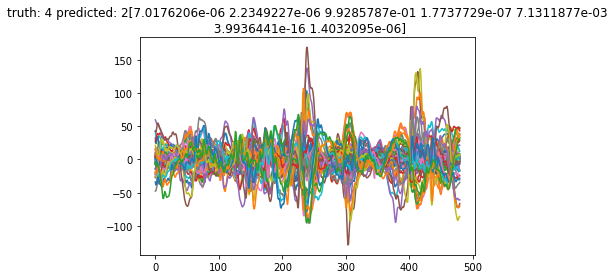

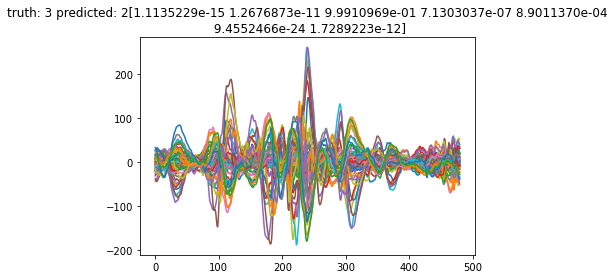

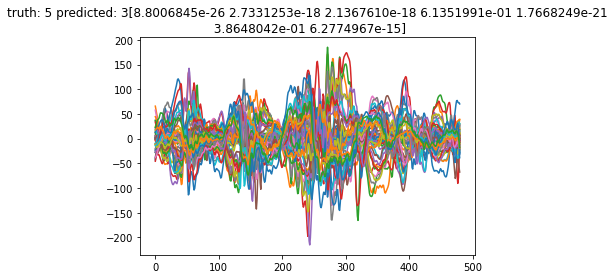

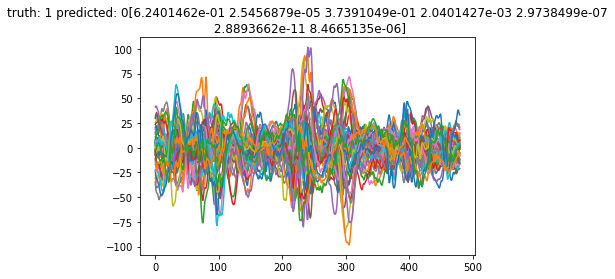

In [16]:
##Plot errors
from scipy.special import softmax
x = np.arange(0, subwindow_len)
y = test_data['emg_windows']
for i in range(len(ys)):
    if(ys[i] != preds[i]):
        plt.figure(i)

        temp = "truth: " + str(ys[i]) + " predicted: " + str(preds[i]) + str(softmax(Xs[i]))
        plt.title(temp)

        for j in range(1, 64):
            plt.plot(x, y[i, :, j])
        plt.show()

In [17]:
typing_test_layout = [65505, 'a', 'w', 'd', ' ', 'j', 'i', 'o', ';']
asciis = [ord(ch) if type(ch) == str else ch for ch in new_layout]
print(asciis)
idxs = np.argsort(asciis)
# idxs = [0, 2, 3, 4, 5, 1]
print(np.argsort(asciis))
print(np.unique(ys))
reord_ys = np.array([idxs[i] for i in ys])
reord_preds = np.array([idxs[i] for i in preds])
print(reord_ys)
print(preds)

[97, 98, 99, 100, 101, 102, 103, 104]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6]
[1 1 0 0 6 0 5 0 3 1 2 5 4 3 2 1 5 6 4 5 6 1 4 6 0 2 5 4 4 5 2 0 1 2 4 1 0
 6 5 2 0 3 3 0 3 5 2 1 4 6 6 2 3 6 5 0 2 3 3 5 6 4 3 4 1 1 6 4 2 3]
[1 1 0 0 6 0 5 0 3 1 2 5 2 3 2 1 5 6 4 5 6 1 4 6 0 2 5 4 4 5 2 0 1 2 4 1 0
 6 5 2 0 2 3 0 3 3 2 1 4 6 6 2 3 6 5 0 2 3 3 5 6 4 3 4 1 0 6 4 2 3]


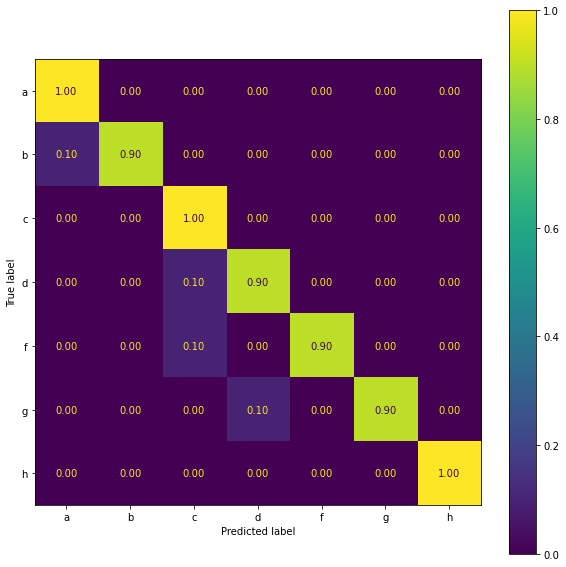

In [18]:
plt.rcParams["figure.figsize"] = (10, 10)
# classes = system.classes
# print(classes)
classes = [ord('a'), ord('b'), ord('c'), ord('d'), ord('f'), ord('g'), ord('h')]
#classes = [ord("\x00"), ord('q'), ord('a'), ord('z'), ord('w'), ord('s'), ord('x'), ord('e'), ord('d'), ord('c'), ord('r'), ord('f'), ord('v'), ord('t'), ord('g'), ord('b')]
labels = [chr(int(c)) for c in classes]
disp = ConfusionMatrixDisplay.from_predictions(reord_ys, reord_preds, normalize='true', values_format='.2f',
                                               display_labels=[chr(int(i)) if i != 65505 else 'shift' for i in classes])


In [19]:
torch.save(system.state_dict(), f"{experiment_dir}/models/{config['name']}.pt")
print(f"experiment_directory: {experiment_dir}")
print(f"checkpoint_name: {config['name']}.pt")

experiment_directory: /home/john/emg_decoder/models/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass
checkpoint_name: derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass.pt


In [20]:
np.save(test_path, test_data)

In [21]:
system.config

{'name': 'derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass',
 'root_dir': '/home/john/emg_decoder',
 'system': 'KeyDecoder',
 'random_seed': 4995,
 'data': {'train_path': '/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_train.npy',
  'val_path': '/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_val.npy',
  'test_path': '/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_test.npy',
  'window_length': 480,
  'train_proportion': 0.8,
  'val_proportion': 0.1,
  'test_proportion': 0.1,
  'train_batch_size': 32,
  'val_batch_size': 32,
  'test_batch_size': 32,
  'num_workers': 4,
  'num_chans': 64,
  'num_classes': 7,
  'classes': [97.0, 98.0, 100.0, 101.0, 102.0, 103.0, 104.0]},
 'model': {'type': 'KeyNet',
  'loss': 'CrossEntropyLoss',
  'num_temporal_filters': 64,
  '